In this notebook we compute the set of features which is active for many different instances of the IOI prompt. 

We hope to use this to gain evidence about whether "important" nodes are prompt-specific. 

In [1]:
import sys 
sys.path.append('/home/daniel/ml_workspace/circuit-finder')

from circuit_finder.pretrained import load_model

model = load_model()

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [2]:
from circuit_finder.data_loader import load_datasets_from_json
from circuit_finder.constants import ProjectDir, device

dataset = "datasets/ioi/ioi_prompts.json"
# dataset_path = ProjectDir / "datasets/ioi/ioi_vanilla_template_prompts.json"
dataset_path = ProjectDir / dataset
batch_size = 16

train_loader, _ = load_datasets_from_json(
    model=model,
    path=dataset_path,
    device = device, # type: ignore
    batch_size = batch_size,
)

In [3]:
from circuit_finder.core.types import Model
from circuit_finder.data_loader import PromptPairBatch

def print_batch(batch: PromptPairBatch, model: Model):
    batch_len = batch.clean.shape[0]
    for i in range(batch_len):
        print(f"Clean prompt: {model.to_string(batch.clean[i])}")
        print(f"Correct answers: {model.to_string(batch.answers[i])}")
        print(f"Wrong answers: {model.to_string(batch.wrong_answers[i])}")
        print(f"Corrupt prompt: {model.to_string(batch.corrupt[i])}")
        print()

print_batch(next(iter(train_loader)), model)

Clean prompt: <|endoftext|>Then, Sarah and Jacob were thinking about going to the garden. Sarah wanted to give a basketball to
Correct answers:  Jacob
Wrong answers:  Sarah
Corrupt prompt: <|endoftext|>Then, Justin and Kate were thinking about going to the garden. William wanted to give a basketball to

Clean prompt: <|endoftext|><|endoftext|>Then, Joseph and Anna had a lot of fun at the store. Anna gave a necklace to
Correct answers:  Joseph
Wrong answers:  Anna
Corrupt prompt: <|endoftext|><|endoftext|>Then, Crystal and Collins had a lot of fun at the store. Max gave a necklace to

Clean prompt: <|endoftext|>Then, Austin and Andre were thinking about going to the station. Austin wanted to give a necklace to
Correct answers:  Andre
Wrong answers:  Austin
Corrupt prompt: <|endoftext|>Then, Emily and Collins were thinking about going to the station. David wanted to give a necklace to

Clean prompt: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [4]:
# For each batch, get the set of active nodes. 
import torch
from jaxtyping import Float
from collections import defaultdict
from circuit_finder.core.types import Node, ModuleName, get_node_name, LayerIndex

def get_active_nodes(module_name: ModuleName, layer: LayerIndex, act: Float[torch.Tensor, "seq dim"], threshold: float = 0.0) -> set[Node]:
    active_nodes = set()
    # Get the nonzero indices
    indices = (act > threshold).nonzero()
    for token_idx, feature_idx in indices:
        active_nodes.add(get_node_name(module_name, layer, int(token_idx.item()), int(feature_idx.item())))
    return active_nodes

def get_active_nodes_from_cache(cache: dict[str, Float[torch.Tensor, "batch seq dim"]], threshold: float = 0.0) -> dict[int, set[Node]]:
    all_nodes = defaultdict(set)
    len_batch = cache['blocks.0.attn.hook_z.hook_sae_acts_post'].shape[0]
    for hook_name, batch_act in cache.items():
        for batch_idx in range(len_batch):
            act = batch_act[batch_idx]
            layer = int(hook_name.split(".")[1])
            module_name = hook_name.split(".")[2]
            nodes = get_active_nodes(module_name, layer, act, threshold) # type: ignore
            all_nodes[batch_idx].update(nodes)
    return all_nodes

In [5]:
import torch
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders

saes = list(load_attn_saes().values())
transcoders = list(load_hooked_mlp_transcoders().values())

all_nodes = defaultdict(set)
with torch.no_grad():
    for n_batch, batch in enumerate(train_loader):
        with splice_model_with_saes_and_transcoders(model, transcoders, saes) as spliced_model:
            _, cache = spliced_model.run_with_cache(batch.clean, names_filter = lambda x: "hook_sae_acts_post" in x)
            nodes = get_active_nodes_from_cache(cache, threshold=0.0) # type: ignore
            for example_idx, n in nodes.items():
                all_nodes[example_idx + n_batch * batch_size] = n

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [6]:
def compute_pairwise_intersection_over_union(nodes: dict[int, set[Node]]) -> float:
    for i, nodes_i in nodes.items():
        for j, nodes_j in nodes.items():
            if i != j:
                intersection = len(nodes_i.intersection(nodes_j))
                union = len(nodes_i.union(nodes_j))
                iou = intersection / union
                print(f"IoU between batch {i} and batch {j}: {iou}")

def compute_intersection_over_union(nodes: dict[int, set[Node]]) -> float:
    union_all = set()
    for i, nodes_i in nodes.items():
        union_all.update(nodes_i)

    intersection_all = union_all.copy()
    for i, nodes_i in nodes.items():
        print(i)
        intersection_all.intersection_update(nodes_i)

    intersection = len(intersection_all)
    union = len(union_all)
    iou = intersection / union
    print(f"Intersection over union: {iou}")

    return intersection_all

intersection_all = compute_intersection_over_union(all_nodes)


# compute_pairwise_intersection_over_union(nodes)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
Intersection over union: 0.0024871635057727125


In [7]:
print(len(intersection_all))
print(intersection_all)

419
{'attn.5.18.36109', 'mlp.2.0.6466', 'mlp.1.4.19544', 'mlp.2.0.11279', 'mlp.2.0.7720', 'mlp.4.0.3865', 'mlp.2.16.10271', 'mlp.3.0.17241', 'mlp.3.0.12337', 'mlp.2.0.19379', 'mlp.1.0.24065', 'mlp.2.0.6917', 'mlp.11.17.3153', 'mlp.10.11.18656', 'mlp.1.20.9645', 'mlp.1.0.7590', 'mlp.0.0.19738', 'mlp.2.0.20380', 'mlp.2.0.3342', 'mlp.2.0.15904', 'mlp.2.0.17122', 'mlp.1.0.9965', 'mlp.1.0.1371', 'mlp.9.20.5792', 'mlp.2.0.13822', 'mlp.0.0.10613', 'mlp.2.0.9736', 'attn.1.0.17148', 'attn.0.20.2710', 'mlp.10.9.18656', 'mlp.2.0.301', 'mlp.10.9.13809', 'mlp.5.0.17025', 'mlp.2.0.602', 'mlp.1.0.2929', 'mlp.10.8.13459', 'mlp.1.0.18422', 'mlp.1.0.21260', 'mlp.2.0.3538', 'mlp.1.0.12480', 'attn.5.16.36109', 'mlp.2.0.22372', 'mlp.2.0.2060', 'mlp.3.0.15354', 'mlp.11.0.20483', 'mlp.5.0.3472', 'mlp.0.0.5530', 'mlp.2.0.14487', 'mlp.1.14.9645', 'mlp.10.11.23264', 'mlp.2.0.22150', 'mlp.2.0.795', 'mlp.2.0.17281', 'mlp.2.0.9139', 'attn.10.1.4437', 'mlp.2.0.8428', 'mlp.1.0.15274', 'mlp.5.0.20971', 'mlp.2.0.13482

In [9]:
import pandas as pd

from circuit_finder.core.types import parse_node_name

rows = []
for node in intersection_all:
    module_name, layer, token_idx, feature_idx = parse_node_name(node)
    rows.append({
        "module_name": module_name,
        "layer": layer,
        "token_idx": token_idx,
        "feature_idx": feature_idx,
    })
df = pd.DataFrame(rows)
df.head()

,module_name,layer,token_idx,feature_idx
0,attn,5,18,36109
1,mlp,2,0,6466
2,mlp,1,4,19544
3,mlp,2,0,11279
4,mlp,2,0,7720


364


Text(0.5, 1.0, 'Counts per layer')

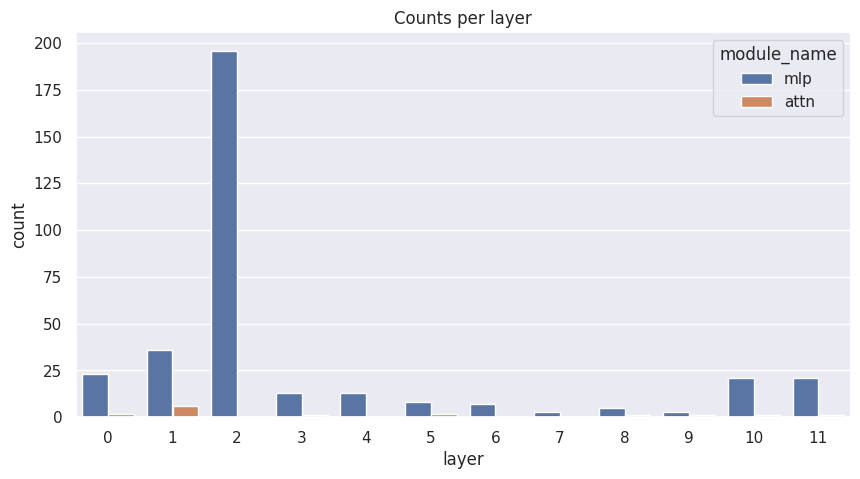

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set_theme()

# Barplot of the counts per layer, after dropping token duplicates 
plot_df = df[['module_name', 'layer', 'feature_idx']].drop_duplicates()
print(len(plot_df))
plt.figure(figsize=(10, 5))
sns.countplot(data=plot_df, x='layer', hue='module_name')
plt.title("Counts per layer")

Text(0.5, 1.0, 'Counts per token index')

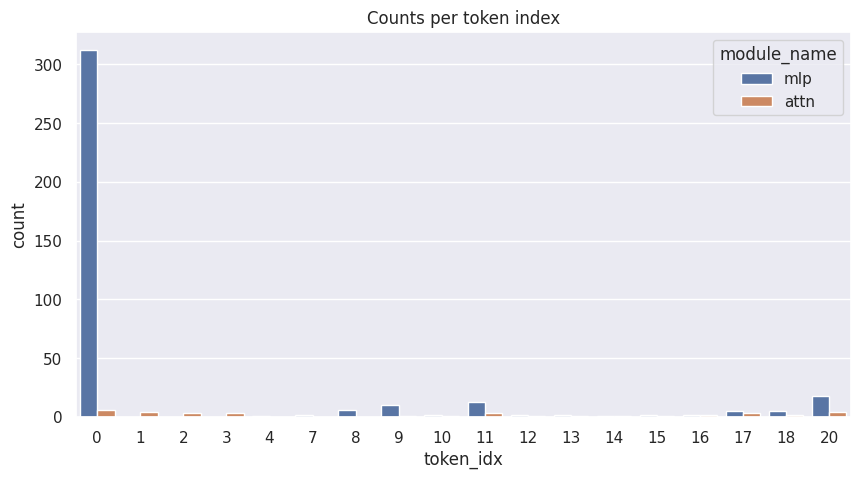

In [23]:
# Barplot of the counts per token position
# plot_df = df[['module_name', 'layer', 'feature_idx']].drop_duplicates()
# print(len(plot_df))
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='token_idx', hue='module_name')
plt.title("Counts per token index")

In [19]:
df[df.layer == 9]

,module_name,layer,token_idx,feature_idx
23,mlp,9,20,5792
139,attn,9,0,13021
173,mlp,9,0,5463
188,attn,9,2,13021
327,mlp,9,0,22194
371,attn,9,3,13021
402,attn,9,1,13021


In [25]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list


layer_11_mlp_features = df[(df.layer == 11) & (df.module_name == "mlp")]['feature_idx'].tolist()
print(layer_11_mlp_features)
get_neuronpedia_url_for_quick_list(11, layer_11_mlp_features, 'tres-dc')

[3153, 20483, 2270, 23503, 19921, 21617, 21617, 9147, 21818, 13918, 6567, 7642, 20460, 12053, 2347, 18831, 4603, 19871, 12410, 1303, 11216, 21642]


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%223153%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%2220483%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%222270%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%2223503%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%2219921%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%2221617%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%2221617%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%2

In [ ]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list


layer_9_att_features = df[(df.layer == 9) & (df.module_name == "attn")]['feature_idx'].tolist()
print(layer_9_att_features)
get_neuronpedia_url_for_quick_list(9, layer_9_att_features, 'att-kk')

In [21]:
df[df.layer == 10]

layer_10_att_features = df[(df.layer == 10) & (df.module_name == "attn")]['feature_idx'].tolist()
print(layer_10_att_features)
get_neuronpedia_url_for_quick_list(10, layer_10_att_features, 'att-kk')

[4437, 4437, 4437, 4437]


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224437%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224437%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224437%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224437%22%7D%5D'

In [ ]:
from circuit_finder.core.types import parse_node_name
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

for node in intersection_all:
    module_name, layer, token_idx, feature_idx = parse_node_name(node)
    sae_set = {"mlp": "tres-dc", "attn": "att-kk"}
    url = get_neuronpedia_url_for_quick_list(layer, [feature_idx], sae_set[module_name])
    print(url)
    


https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-tres-dc%22%2C%20%22index%22%3A%20%225371%22%7D%5D
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%223-tres-dc%22%2C%20%22index%22%3A%20%222899%22%7D%5D
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%223-tres-dc%22%2C%20%22index%22%3A%20%227382%22%7D%5D
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%227-tres-dc%22%2C%20%22index%22%3A%20%2218163%22%7D%5D
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%223-att-kk%22%2C%20%22index%22%3A%20%2219666%22%7D%5D
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22model